In [130]:
import numpy as np
import pandas as pd

from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset

import os
from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.stats import entropy
from scipy.signal import welch
from scipy.fftpack import fft

from Lilygo.Recording import Recording, data_integrity
from Lilygo.Dataset import Dataset

import joblib
from mpl_toolkits.mplot3d import Axes3D
import math

In [98]:
def get_gravity(data):
    filtered_data = np.zeros_like(data)
    # Parameters in IIR filter
    alpla = [1, -1.979133761292768, 0.979521463540373]
    beta = [0.000086384997973502, 0.00012769995947004, 0.000086384997973502]
    # Formula of IIR filter
    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

def get_highpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.905384612118461, 0.910092542787947]
    beta = [0.953986986993339, -1.907503180919730, 0.953986986993339]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data


def get_lowpass(data):
    filtered_data = np.zeros_like(data)  # filtered_data
    alpla = [1, -1.80898117793047, 0.827224480562408]
    beta = [0.096665967120306, -0.172688631608676, 0.095465967120306]

    for i in range(2, len(data)):
        filtered_data[i] = alpla[0] * (data[i] * beta[0] + data[i-1] * beta[1] + data[i-2] * beta[2] - filtered_data[i-1] * alpla[1] - filtered_data[i-2] * alpla[2])
    return filtered_data

In [34]:
# Get the path of all traces
dir_traces = 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_001.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_002.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_003.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_004.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_005.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_006.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_007.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_008.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_009.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_010.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_011.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_012.json', 'E:\\A.ETUDES\\22_24_ETH\\S2\\4-MHealth\\data\\train\\train_trace_013.json'

In [140]:
# Read phone accelerometer data
trace = Recording(dir_traces + 'train_trace_001.json')
ax_data = trace.data['phone_ax']
ay_data = trace.data['phone_ay']
az_data = trace.data['phone_az']
ax = np.asarray(ax_data.values)
ay = np.asarray(ay_data.values)
az = np.asarray(az_data.values)

# Get timestamps
t = ax_data.timestamps #[ms]
print(len(t))
print(t)

# sampling_rate = len(timestamps)/timestamps[-1]
# print(sampling_rate)

55489
[0.00000000e+00 9.92144247e-03 1.98428849e-02 ... 5.50501157e+02
 5.50511079e+02 5.50521000e+02]


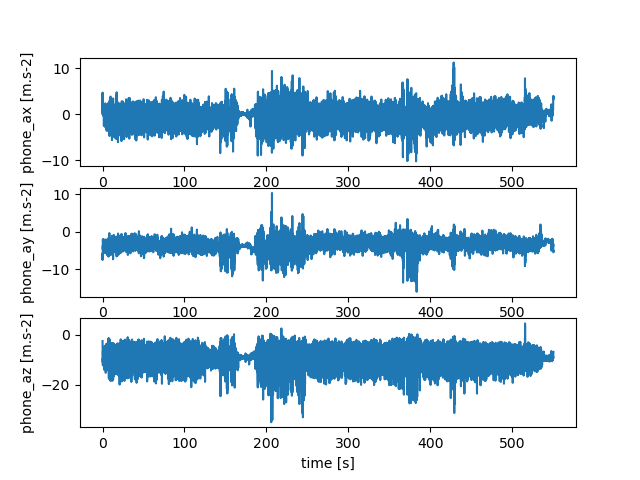

In [141]:
# Plot ---------------------------------------
plt.figure()
# x
plt.subplot(3,1,1)
plt.plot(t, ax)
plt.ylabel('phone_ax [m.s-2]')
# y
plt.subplot(3,1,2)
plt.plot(t, ay)
plt.ylabel('phone_ay [m.s-2]')
# z
plt.subplot(3,1,3)
plt.plot(t, az)
plt.ylabel('phone_az [m.s-2]')
plt.xlabel('time [s]')
plt.show()

## Remove gravity

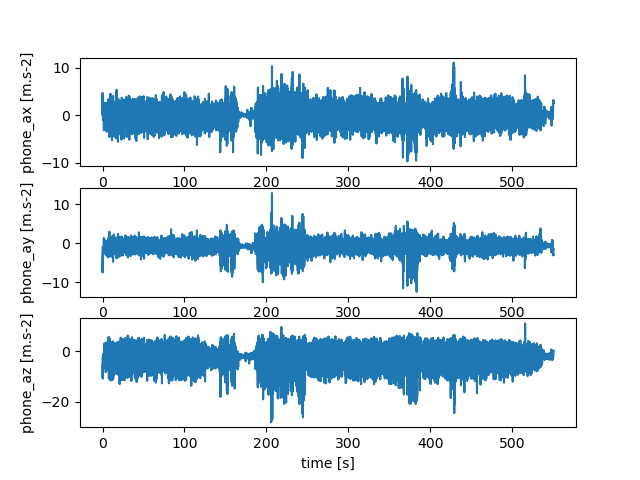

In [150]:
ax_0g = ax - get_gravity(ax)
ay_0g = ay - get_gravity(ay)
az_0g = az - get_gravity(az)

# Plot ---------------------------------------
plt.figure()
# x
plt.subplot(3,1,1)
plt.plot(t, ax_0g)
plt.ylabel('phone_ax [m.s-2]')
# y
plt.subplot(3,1,2)
plt.plot(t, ay_0g)
plt.ylabel('phone_ay [m.s-2]')
# z
plt.subplot(3,1,3)
plt.plot(t, az_0g)
plt.ylabel('phone_az [m.s-2]')
plt.xlabel('time [s]')
plt.show()

In [ ]:
dt = t[1] - t[0]

# Sensor fusion
angle = gyro

## Integration to get velocity and acceleration

In [149]:
vx, vy, vz = np.zeros(len(t)), np.zeros(len(t)), np.zeros(len(t))
for i in range(len(t)):
    print(i, '/', len(t)-1)
    # Compute the area under the curve
    vx[i] = np.trapz(ax_0g[:i], t[:i])
    vy[i] = np.trapz(ay_0g[:i], t[:i])
    vz[i] = np.trapz(az_0g[:i], t[:i])

0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

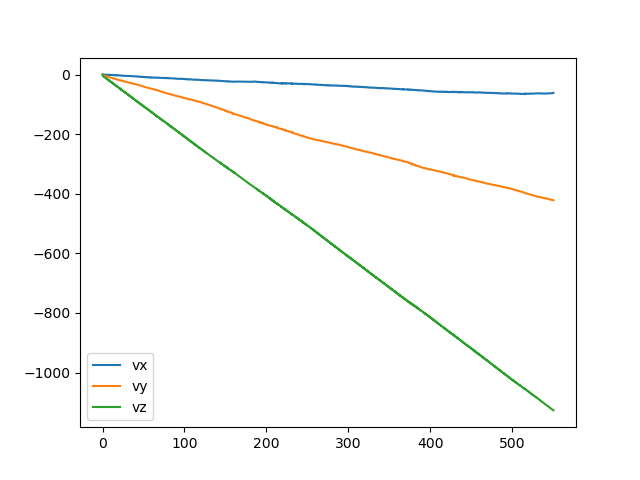

In [151]:
plt.figure()
plt.plot(t, vx, label='vx')
plt.plot(t, vy, label='vy')
plt.plot(t, vz, label='vz')
plt.legend()
plt.show()

In [122]:
# Integration
dt = t[1] - t[0]
vx, vy, vz = [0], [0], [0]

for i in range(len(t)-1):
    print(i, '/', len(t)-1)
    vx = vx + [vx[-1] + ax[i]*dt]
    vy = vy + [vy[-1] + ay[i]*dt]
    vz = vz + [vz[-1] + az[i]*dt]

0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

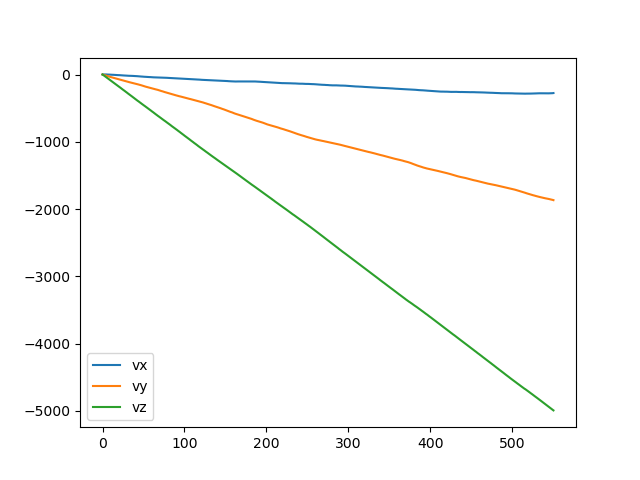

In [123]:
plt.figure()
plt.plot(t, vx, label='vx')
plt.plot(t, vy, label='vy')
plt.plot(t, vz, label='vz')
plt.legend()
plt.show()

In [124]:
x, y, z = [0], [0], [0]

for i in range(len(t)-1):
    print(i, '/', len(t)-1)
    x = x + [x[-1] + vx[i]*dt]
    y = y + [y[-1] + vy[i]*dt]
    z = z + [z[-1] + vz[i]*dt]
    


0 / 55488
1 / 55488
2 / 55488
3 / 55488
4 / 55488
5 / 55488
6 / 55488
7 / 55488
8 / 55488
9 / 55488
10 / 55488
11 / 55488
12 / 55488
13 / 55488
14 / 55488
15 / 55488
16 / 55488
17 / 55488
18 / 55488
19 / 55488
20 / 55488
21 / 55488
22 / 55488
23 / 55488
24 / 55488
25 / 55488
26 / 55488
27 / 55488
28 / 55488
29 / 55488
30 / 55488
31 / 55488
32 / 55488
33 / 55488
34 / 55488
35 / 55488
36 / 55488
37 / 55488
38 / 55488
39 / 55488
40 / 55488
41 / 55488
42 / 55488
43 / 55488
44 / 55488
45 / 55488
46 / 55488
47 / 55488
48 / 55488
49 / 55488
50 / 55488
51 / 55488
52 / 55488
53 / 55488
54 / 55488
55 / 55488
56 / 55488
57 / 55488
58 / 55488
59 / 55488
60 / 55488
61 / 55488
62 / 55488
63 / 55488
64 / 55488
65 / 55488
66 / 55488
67 / 55488
68 / 55488
69 / 55488
70 / 55488
71 / 55488
72 / 55488
73 / 55488
74 / 55488
75 / 55488
76 / 55488
77 / 55488
78 / 55488
79 / 55488
80 / 55488
81 / 55488
82 / 55488
83 / 55488
84 / 55488
85 / 55488
86 / 55488
87 / 55488
88 / 55488
89 / 55488
90 / 55488
91 / 5548

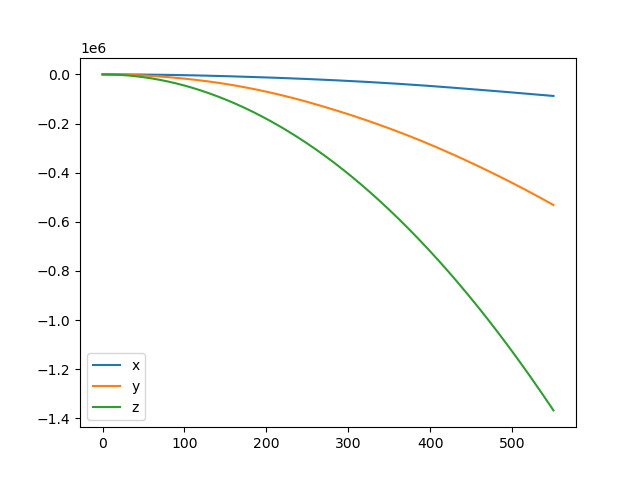

In [125]:
plt.figure()
plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.plot(t, z, label='z')
plt.legend()
plt.show()

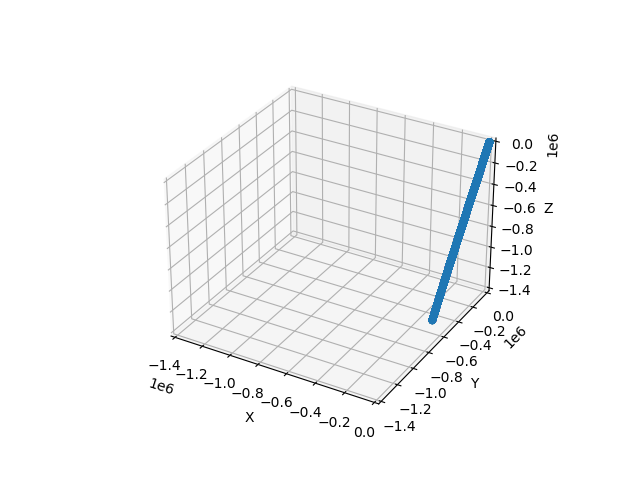

In [129]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set the limits for each axis
ax.set_xlim([-1400000, 0])
ax.set_ylim([-1400000, 0])
ax.set_zlim([-1400000, 0])

plt.show()

In [3]:
trace = Recording('E:/A.ETUDES/22_24_ETH/S2/4-MHealth/data/train/train_trace_001.json')
print(list(trace.data.keys()))

if not(trace.labels is None):
    # print("\r\nLabels: ")
    print(trace.labels)

['phone_orientationy', 'phone_mz', 'longitude', 'phone_roty', 'packetNumber', 'mx', 'note', 'ay', 'phone_gravz', 'phone_lay', 'lostPackets', 'ax', 'timestamp', 'phone_rotz', 'phone_ax', 'phone_az', 'speed', 'altitude', 'phone_pressure', 'phone_gravy', 'temperature', 'my', 'mz', 'phone_rotm', 'latitude', 'az', 'gx', 'phone_lax', 'phone_rotx', 'phone_gy', 'phone_ay', 'phone_orientationx', 'bearing', 'phone_laz', 'phone_steps', 'gz', 'phone_mx', 'phone_orientationz', 'gy', 'phone_gravx', 'phone_gz', 'phone_gx', 'phone_my']
{'board_loc': 2, 'path_idx': 4, 'activities': [1]}
